# Lab 02 : Angular speed of the Earth

## Objectives

In this lab we will solve a real problem which means we will encounter a number of side issues to distract us from our main task.
We have already seen some of the issues in the prelab.
Also, typically when doing calculations we want to avoid writing loops if we can help it since loops are cumbersome to write and slow to run.
Array slicing is a powerful feature of `numpy` arrays that makes it possible to avoid writing loops in many cases.
We will discuss array slicing in more detail in the future, for now we can use a simple form of it, as discussed below.

## Basic Problem

We wish to find the angular velocity of the Earth as a function of time as it orbits the Sun.
This does not sound too hard but is more involved than we may first think.
To make things a little simpler we will only find the angular speed of the Earth, $\mathrm{d}\theta/\mathrm{d}t \equiv \dot{\theta}(t)$, not its direction.
From Kepler’s second law we know that the angular speed in an elliptical orbit is not constant: the radius of the orbit sweeps out equal area in equal time.
When we study central forces in classical mechanics we learn that this can be understood in terms of conservation of angular momentum and further that we can easily write down equations of motion and solve them in terms of integrals, giving expressions for how both the radial and angular position of an object behaves in such an orbit.
We are interested in the angular position which for an elliptical orbit is given by
\begin{align}
  t(\theta) &= \frac{\tau}{2\pi}(1-e^2)^{3/2} \int_0^\theta \frac{\mathrm{d}\theta'}{(1+e\cos\theta')^2} \\
            &= \frac{\tau}{2\pi}\left[ 2\tan^{-1}\left(\sqrt{\frac{1-e}{1+e}}\tan(\theta/2)\right)
                        - \frac{e\sqrt{1-e^2}\sin\theta}{1+e\cos\theta}
                    \right]
\end{align}
Here $\tau$ is the period of the orbit, $0 \leq e < 1$ is the eccentricity of the orbit, and I have chosen $t=0$ at periapsis (the distance of closest approach).
The difficulty we encounter is not in doing the integral, that we **can** do, it is in inverting this function.
We have written an equation for $t(\theta)$ but we really want $\theta(t)$.
One approach to inverting this would be to do what we did in the previous lab: use a root finder.
That is time consuming and not amenable to taking the derivative we will need.
In this lab we will instead interpolate using a spline.

The equation given above comes from a direct solution of the equations of motion.
Historically this result has been manipulated in many ways.
In fact, even before Newton’s laws were known this problem was studied observationally.
An alternative approach to the problem is through **Kepler’s equation**:
$$\omega t = \psi - e \sin \psi.$$
Here $\omega t$ is called the *mean anomaly* and $\psi$ is called the *eccentric anomaly*.
(Astronomers seem to like anomalies.)
In this formula the *average speed* is given by $\omega = 2\pi/\tau$ so that $0 \leq \omega t < 2\pi$ for $0 \leq \psi \leq 2\pi$.
The angle $\psi$ can be related to the angular position of the Earth, $\theta$, in many ways; we will use
$$\cos\theta = \frac{\cos\psi-e}{1-e\cos\psi}.$$
Note that in the pre-computer age over one hundred methods were developed to invert this equation.
It drove the development of many numerical techniques.

## Basic Procedure

Conceptually the procedure we want to follow is straightforward:
1. Calculate $t(\theta)$ for a grid of values using the two methods discussed above: (1) the first equation for $t(\theta)$ and (2) Kepler's equation.
2. Construct a spline that inverts these to give $\theta(t)$.
3. Calculate the angular velocity, $\dot\theta(t)$, by calculating the first derivative of our spline. Note that we can do this at any time, t, so we will do this on a finely spaced time grid.
4. …
4. Profit?

Naturally it will not be quite so easy.

We will only consider the motion of the Earth, but the approach works for any object in an elliptical orbit so all functions we write should be defined in terms of $e$ and $\tau$ instead of explicitly plugging in numbers.
Ultimately we do need numbers, for the Earth: $e=0.01671123$ and $\tau=365.25636$ days.

As a final note, we are solving a real problem but in a simple way.
If we were going to do this for a real research problem we would need to be more careful than we are here.
We would want to perform more checks, consider more methods, ….
In particular, we are not going to do a good job of exploring the accuracy of our methods.

The end results of this work will be two plots.
You should **always check your intermediate results** as you are developing your solution, even when these checks are not asked for or even suggested.
This includes looking at arrays generated, producing quick plots, *etc*.
You should remove these checks from your final notebook document.
We only want the necessary steps and results in our final notebook.

## Initialization

As always initialize, your environment now by loading all modules required and setting up the plotting environment.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interp

Although we will define all of our functions to accept arbitrary values of the eccentricity and period, it is still useful to define variables to hold the values for the Earth.
It is good to define these constants early and then just use them when needed.
Define variables for the eccentricity and period of the Earth using the values given above.
Also calculate the average angular speed, $\omega$, for the Earth, we will also use this below.
(Hint: What is the relationship between the period and the angular speed (or angular frequency)?)

In [2]:
e = 0.01671123
tau = 365.25636
omega = 1/tau * 2 * np.pi

## $t(\theta)$ Analysis

We will begin by analyzing the first equation given above for $t(\theta)$.
Define a function that evaluates this equation for arbitrary angles.
Recall from the prelab that care must be taken when calculating the arctangent.
The correct quadrant for the calculation can be determined as discussed in the prelab, by using the `arctan2` function.
Also recall that it is usual for numerical routines to work in radians for angles, not degrees.
In this case to avoid confusion **write your function to accept radians**, even if we prefer to work in degrees (as we will below) this will hopefully make it easier to avoid mistakes.
Finally, remember that all nontrivial functions must be documented.

In [ ]:
def t_theta_func(theta, e, period):
    """
    Given the angle theta, eccentricity, period of the orbit, find what time t the satellite is at in the orbit.

    Parameters
    ---
    theta : number
        the angle of the satellite in its orbit, in radians where theta is in the range [0, 2*pi].
    e : number
        the eccentricity of the orbit, in the range [0, 1]; for earth, 0.01671123.
    period : number
        the period of the orbit, in the same units as t

    Returns
    ---
    t : number
        the time parameter t in the range [0, period) as implied by theta, e, and period
    """
    return period/(2 * np.pi) * (
        2 * np.arctan2(
            np.sqrt((1 - e)/(1 + e)) * np.sin(theta / 2),
            np.cos(theta / 2)
        )
        - (e * np.sqrt(1 - e**2) * np.sin(theta)) / (1 + e * np.cos(theta))
    )

As noted in PreLab01, it is important to always test your code as you develop it.
Occasionally, such tests will be provided for you, like the cell below.
You should run this cell after you have defined your function.
If it fails, that means there is an error in your function.
You should go back and fix your function.

In the future you will be expected to provide your own test cases.
Typically these will be simple cases than you can determine analytically from some physical argument.
Here you are given an arbitrary sampling of values that will more fully test your function than would be found for simpler values.

In [4]:
assert(np.allclose(np.array([0.       ,  87.34408448, 193.11578584, 316.00273203]),
    t_theta_func(np.deg2rad([0, 88, 190, 310]), 0.01671123, 365.25636)))

We will now use a spline to estimate $\theta(t)$ by numerically inverting this function.
To do so, first construct an array of angles, $\theta$, from 0 to 360 degrees in steps of 1 degree.
Use this and the function defined above to construct a spline representing $\theta(t)$.
Recall from the prelab that trigonometric functions do **not** take their arguments in degrees, but as humans it is more natural for us to think in degrees.

We wish to evaluate the angular speed, $\dot\theta(t)$, on a finely spaced grid.
To this end, construct an array of 5,000 points in time from zero to the period of the orbit.
(You will also use this exact same array below.)
Finally, use the spline to calculate an array of the angular speeds.
Give this array a "sensible" name as we will use it below for our main plot.

In [5]:
angles = np.linspace(0, 360, 361)
theta_spline = interp.make_interp_spline(t_theta_func(np.deg2rad(angles), e, tau), np.deg2rad(angles))

ts = np.linspace(0, tau, 5000)
angular_speeds = theta_spline(ts, 1)

## Kepler's Equation

We will now follow a similar procedure to calculate the angular speed using Kepler's equation instead.
Once again we encounter an issue with evaluating inverse trigonometric functions, here related to the arccosine.

In using Kepler's equation we need to calculate $t(\psi)$ and $\theta(\psi)$.
Even though $\psi$ takes values from $0$ to $2\pi$, for reasons discussed below, we will only use half this interval.
Construct an array for $\psi$ from 0 to 180 degrees (inclusive) in steps of 1 degree.
Define a function for calculating $t(\psi)$ and use it to construct an array evaluated over the $\psi$ array we just created.
There is no subtlety in doing this, we can directly apply the equations as written above.

In [ ]:
def kepler_t(psi, e, period):
    """
    Calculate t using Kepler's equation.

    Parameters
    ---
    psi : number
        the eccentric anomaly psi, in the range [0, pi].
    e : number
        the eccentricity of the orbit, in the range [0, 1]; for earth, 0.01671123.
    period : number
        the period of the orbit, in the same units as t

    Returns
    ---
    t : number
        the time parameter t in the range [0, period) as implied by theta, e, and period
    """
    return (psi - e * np.sin(psi)) * (period / (2 * np.pi))

psis = np.linspace(0, 180, 181)
kepler_ts = kepler_t(np.deg2rad(psis), e, tau)

As above, here are tests you can use to verify your code.

In [7]:
assert(np.allclose(np.array([1.99529842,  28.95245432, 175.40758142]),
                   kepler_t(np.deg2rad([2, 29, 173]), 0.01671123, 365.25636)))

Next we want to calculate $\theta(\psi)$.
Unfortunately this involves the arccosine which suffers from the same problem as the arctangent: it is not uniquely defined.
In this case we do not have the equivalent of `arctan2` defined for the arccosine.
For $0\le\psi\le\pi$ there is no problem, we can invert using the `arccos` function from `numpy`.
When you look up its documentation you see it returns a value in the range 0 to $\pi$, which is precisely what we want.
For $\psi>\pi$ we do have a problem as the `arccos` function will still only return a value in the range 0 to $\pi$.
We will deal with the complete interval below.
For now, we just focus on the part of the orbit we can easily calculate.

Define a function for computing $\theta(\psi)$ based on the expression given at the beginning of the lab and using the `arccos` function from `numpy`.
This function will only be valid for $\psi\in[0,\pi]$. This is why we created the $\psi$ array as specified above.
Finally use this function and the $\psi$ array to compute an array for $\theta(\psi)$.

In [ ]:
def theta_psi(psi, e):
    """
    Find theta as a function of the eccentric anomaly psi and the eccentricity of the orbit e.

    Parameters
    ---
    psi : number
        the eccentric anomaly psi, in the range [0, pi].
    e : number
        the eccentricity of the orbit, in the range [0, 1]; for earth, 0.01671123.

    Returns
    ---
    theta : number
        the angle theta of the satellite in the orbit, in the range [0, pi].
    """
    return np.arccos(
        (np.cos(psi) - e)/
        (1 - e*np.cos(psi))
    )

theta_psis = theta_psi(np.deg2rad(psis), e)

Yet again, some tests.

In [9]:
assert(np.allclose(np.array([0.01774742, 1.50019041, 1.84870346]),
                   theta_psi(np.deg2rad([1, 85, 105]), 0.01671123)))

We now have arrays for $t(\psi)$ and $\theta(\psi)$.
Much like the $t(\theta)$ analysis we can use these to construct a spline that defines the function $\theta(t)$.
You should do this below.

Unfortunately this spline will only be valid for $t\in [0,\tau/2]$, that is, over half an orbit.
We want to use it to find $\dot\theta(t)$ over a complete orbit.
Here is where we can use symmetry!

**Physically** we know how the first half of the orbit is related to the second half of the orbit.
Thus, if we know how the Earth is moving at an angular position $\theta \in [0,\pi]$, or equivalently at a time $t \in [0,/\tau/2]$, we also know how it is moving at an angular position $2\pi-\theta$ or time $\tau-t$.
Think about this, it will tell us how to proceed.

**Mathematically** there are a number of transformations we know from trigonometry that we can use to verify this physical picture.
One is to recall that $\cos(2\pi-\theta)=\cos\theta$.
Thus, from the relationship given above we have
$$\cos(2\pi-\theta) = \frac{\cos(2\pi-\psi)-e}{1-e\cos(2\pi-\psi)},$$
so that
$$\theta=2\pi - \cos^{-1}\left[ \frac{\cos(2\pi-\psi)-e}{1-e\cos(2\pi-\psi)} \right]$$
which is valid for the rest of the range, $\psi \in [\pi,2\pi]$.
Equivalently, this shows us how to determine $\theta(t)$ for $\tau \in [\tau/2,\tau]$.

Putting this all together we can now proceed to describe the full orbit.

We want to construct an array for the angular speed of the Earth on the same finely spaced grid we used in the $t(\theta)$ analysis.
To avoid having to write loops, deal with growing the length of arrays, *etc*., we will use some features provided by `numpy`.
1. Create an array of the correct length to hold the angular speed of the Earth over a complete orbit. This can be done easily by using `np.zeros_like`. Suppose we called our fine time grid `tgrid`, then `np.zeros_like(tgrid)` creates a new array of the same length and type as `tgrid` but filled with zeros.
2. Use array slicing to fill in pieces of the array. As noted previously, we will study array slicing in more detail in the future, here we will use one simple case. Suppose `tgrid` has length `N` (where `N` is even so we do not need to treat `N/2` as a special case). Then for some array `A` of the same length, `A[:N//2]` will represent the first half of the array `A` and `A[N//2:]` will represent the second half. We can do a lot of things with these slices, in particular we can assign to them! For example, `A[N//2:]=1` would assign `1` to the second half of the array and leave the first half unchanged.
3. You will notice that I wrote `N//2`, not `N/2`, why?  In Python array indices must be integers, but recall that even division of integers returns floating point numbers (sigh). To fix this, we use the new division operator, `//`, that forces integer division, so `N//2` will do what we want. (This is mostly true, `//` has some other quirks that we have briefly mentioned in class but are irrelevant here.)

With the above we can create an array to hold the desired values of $\dot\theta(t)$ for the whole orbit.
Fill in the first half from the derivative of the spline and fill in the second half of the array also from the derivative of the spline but now using the symmetry we discussed above.

In the end you will have an array for the angular speed of the Earth over a complete orbit based on Kepler's equation.

In [10]:
kepler_theta_spline = interp.make_interp_spline(kepler_ts, theta_psis)
kepler_angular_speeds = np.zeros_like(ts)
kepler_angular_speeds[:len(ts)//2] = kepler_theta_spline(ts[:len(ts)//2], 1)
kepler_angular_speeds[len(ts)//2:] = kepler_theta_spline(tau -ts[len(ts)//2:], 1)

## Results

To show off our results we will produce two figures.

### Main Figure

Plot the two versions of $\dot\theta(t)$ calculated above on the *finely spaced time grid*.
Your plot should follow all the rules from the previous labs and prelabs.
Though the computer likes to work in radians, we are more comfortable thinking in degrees so you should convert your angular speed to use degrees, not radians.
(After all, we know approximately how many degrees the Earth moves around the Sun each day.)
Include a horizontal line for the average angular speed of the Earth calculated at the beginning of the lab.
Since you are plotting quantities with units this fact **must** be reflected in the axis labels; typically units are given in parentheses.
Finally, as also noted in the prelab, `matplotlib` tries to show all the data you provide it.
In the process of doing so it tries to guess reasonable limits for the axes; it does not always get this right.
You should adjust these (and anything else) to improve the readability of the plot.

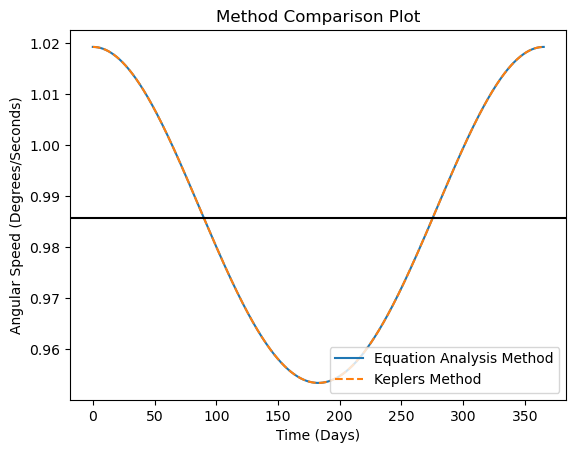

In [11]:
fig = plt.figure()
ax=fig.add_subplot(111)
ax.set_title("Method Comparison Plot")
ax.set_xlabel("Time (Days)")
ax.set_ylabel("Angular Speed (Degrees/Seconds)")
ax.plot(ts, np.rad2deg(angular_speeds), label = "Equation Analysis Method")
ax.plot(ts, np.rad2deg(kepler_angular_speeds), ls = "--", label = "Keplers Method")
ax.axhline(np.rad2deg(omega), color = "k")
ax.legend(loc = 'lower right')

### Comparison of the Methods

One reason for using two methods is that they **must** both produce the same result.
Whenever we perform a numerical computation we should always check if our results make sense or not.
Remember that the computer will always return results, even if they make no sense. Using two different methods at least gives us a consistency check.
If the two methods do not produce very similar results (meaning that the two curves do not lie on top of each other) then something is wrong, go back and find your error!

Though the results look very similar, there are differences.
To study the magnitude of the errors in the methods we have used compute the *absolute difference* between them and produce a plot of these differences.
Typically when we plot errors it makes sense to put them on a semi-logarithmic plot. This can be done most easily using `semilogy` which is exactly like `plot` except that it makes the $y$-axis logarithmic.
Produce a plot for the absolute differences.
Again use all the good practices.
(Note: Since there is only one line in the figure, is it necessary to label it and create a legend?)

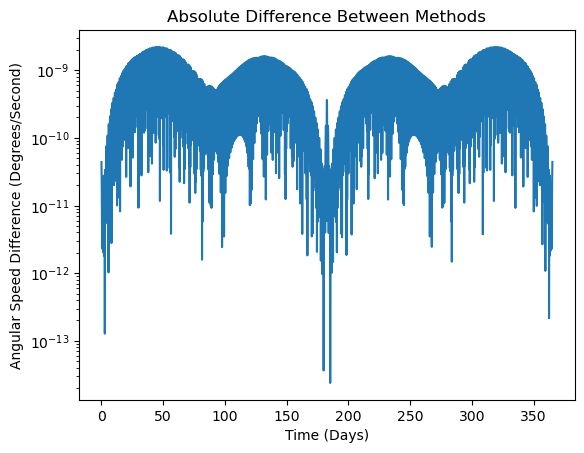

In [13]:
difference = np.abs(np.rad2deg(angular_speeds)-np.rad2deg(kepler_angular_speeds))
fig = plt.figure()
ax2 = fig.add_subplot(111)
ax2.set_title("Absolute Difference Between Methods")
ax2.set_xlabel("Time (Days)")
ax2.set_ylabel("Angular Speed Difference (Degrees/Second)")
ax2.semilogy(ts, difference, label="Difference of Methods")

## Member Participation

See Lab00 for instructions on turning in labs.
We will follow this procedure the entire semester.

In the following cell enter the *Case ID* for each student in the group who participated in this lab.
Again, see Lab00 for more details.
It is expected that you have read and understood those details.

sjl132, avv26, nxm642